# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

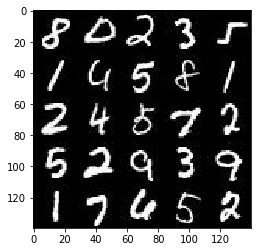

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

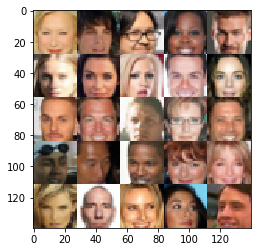

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='valid')
        x1 = tf.maximum(x1*alpha, x1)
        # 12x12x64
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2*alpha, x2)
        # 6x6x128
        x3 = tf.layers.conv2d(x2, 256, 3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3*alpha, x3)
        # 3x3x256
        # flatten layer
        flatten = tf.reshape(x3, (-1, 3*3*256))
        flatten = tf.layers.dropout(flatten, 0.31)
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        # fully_connected layer for input
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1*alpha, x1)
        # 7x7x512
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2*alpha, x2)
        # 14x14x256
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3*alpha, x3)
        # 28x28x128
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x3
        out = tf.tanh(logits) * 0.5
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, alpha):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False, alpha),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get baches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, num_channels = data_shape
    inputs_real, inputs_z, learning_rate_tensor = model_inputs(image_width, image_height, num_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, num_channels, alpha=alpha)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_tensor, beta1=beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        steps = 0
        print_every = 20
        show_every = 100
        losses = []
        samples = []
        sample_z = np.random.uniform(-1, 1, size=(10, z_dim))
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_rate_tensor:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, learning_rate_tensor:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of 100 epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, inputs_z, num_channels, data_image_mode, alpha)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0168... Generator Loss: 6.7497
Epoch 1/2... Discriminator Loss: 0.0335... Generator Loss: 4.3431
Epoch 1/2... Discriminator Loss: 0.0502... Generator Loss: 4.7402
Epoch 1/2... Discriminator Loss: 0.1429... Generator Loss: 2.3337
Epoch 1/2... Discriminator Loss: 0.0438... Generator Loss: 3.8611


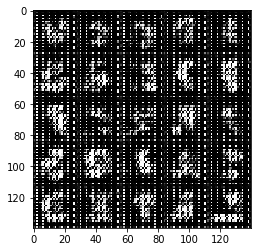

Epoch 1/2... Discriminator Loss: 2.3002... Generator Loss: 1.5219
Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 0.6373
Epoch 1/2... Discriminator Loss: 1.3171... Generator Loss: 0.8798
Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 0.9589
Epoch 1/2... Discriminator Loss: 1.0055... Generator Loss: 1.1223


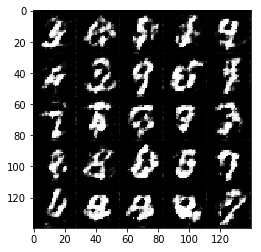

Epoch 1/2... Discriminator Loss: 0.9873... Generator Loss: 1.2343
Epoch 1/2... Discriminator Loss: 1.0111... Generator Loss: 0.8845
Epoch 1/2... Discriminator Loss: 0.8872... Generator Loss: 0.8363
Epoch 1/2... Discriminator Loss: 1.0237... Generator Loss: 0.6923
Epoch 1/2... Discriminator Loss: 0.7681... Generator Loss: 1.2559


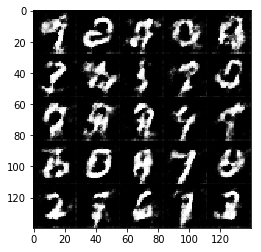

Epoch 1/2... Discriminator Loss: 1.2893... Generator Loss: 0.4332
Epoch 1/2... Discriminator Loss: 1.1380... Generator Loss: 0.9007
Epoch 1/2... Discriminator Loss: 1.4417... Generator Loss: 0.3892
Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 0.5466
Epoch 1/2... Discriminator Loss: 1.1256... Generator Loss: 0.7254


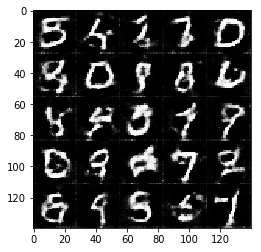

Epoch 1/2... Discriminator Loss: 1.1175... Generator Loss: 1.3817
Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 0.7663
Epoch 1/2... Discriminator Loss: 0.9736... Generator Loss: 1.1666
Epoch 1/2... Discriminator Loss: 1.0706... Generator Loss: 1.0306
Epoch 1/2... Discriminator Loss: 1.0067... Generator Loss: 1.0976


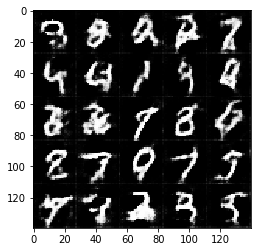

Epoch 1/2... Discriminator Loss: 1.1144... Generator Loss: 0.6553
Epoch 1/2... Discriminator Loss: 1.3098... Generator Loss: 0.4426
Epoch 1/2... Discriminator Loss: 1.1332... Generator Loss: 0.5542
Epoch 1/2... Discriminator Loss: 1.2761... Generator Loss: 0.4462
Epoch 1/2... Discriminator Loss: 1.2216... Generator Loss: 0.6491


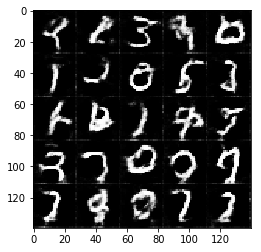

Epoch 1/2... Discriminator Loss: 1.0702... Generator Loss: 0.7845
Epoch 1/2... Discriminator Loss: 1.2078... Generator Loss: 0.4974
Epoch 1/2... Discriminator Loss: 1.0877... Generator Loss: 0.6519
Epoch 1/2... Discriminator Loss: 1.0813... Generator Loss: 0.7633
Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 0.6287


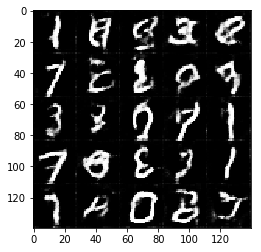

Epoch 1/2... Discriminator Loss: 0.9698... Generator Loss: 1.1935
Epoch 1/2... Discriminator Loss: 1.0756... Generator Loss: 0.6331
Epoch 1/2... Discriminator Loss: 0.8987... Generator Loss: 1.6314
Epoch 1/2... Discriminator Loss: 0.9129... Generator Loss: 1.2706
Epoch 1/2... Discriminator Loss: 0.9648... Generator Loss: 0.8113


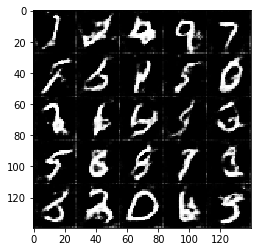

Epoch 1/2... Discriminator Loss: 1.6388... Generator Loss: 0.2852
Epoch 1/2... Discriminator Loss: 1.1549... Generator Loss: 0.6220
Epoch 1/2... Discriminator Loss: 1.1807... Generator Loss: 0.5469
Epoch 1/2... Discriminator Loss: 0.9797... Generator Loss: 0.7386
Epoch 1/2... Discriminator Loss: 1.0021... Generator Loss: 0.7355


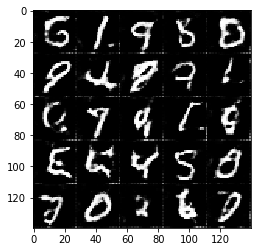

Epoch 1/2... Discriminator Loss: 1.1859... Generator Loss: 0.6263
Epoch 2/2... Discriminator Loss: 1.5862... Generator Loss: 0.3123
Epoch 2/2... Discriminator Loss: 1.0376... Generator Loss: 0.7644
Epoch 2/2... Discriminator Loss: 1.0381... Generator Loss: 0.8897
Epoch 2/2... Discriminator Loss: 1.0087... Generator Loss: 0.9707


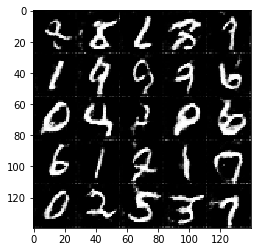

Epoch 2/2... Discriminator Loss: 1.0911... Generator Loss: 0.6260
Epoch 2/2... Discriminator Loss: 1.0580... Generator Loss: 0.6337
Epoch 2/2... Discriminator Loss: 1.0495... Generator Loss: 0.6212
Epoch 2/2... Discriminator Loss: 1.2177... Generator Loss: 0.6442
Epoch 2/2... Discriminator Loss: 1.0451... Generator Loss: 0.6521


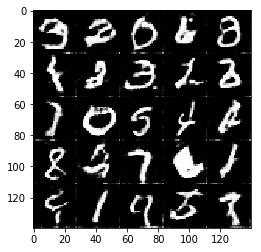

Epoch 2/2... Discriminator Loss: 0.9374... Generator Loss: 1.4364
Epoch 2/2... Discriminator Loss: 1.1472... Generator Loss: 0.6166
Epoch 2/2... Discriminator Loss: 1.0294... Generator Loss: 0.7215
Epoch 2/2... Discriminator Loss: 1.0919... Generator Loss: 0.5893
Epoch 2/2... Discriminator Loss: 0.9535... Generator Loss: 1.4183


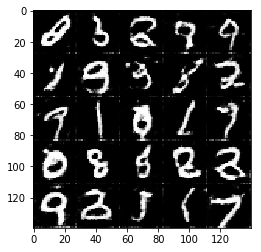

Epoch 2/2... Discriminator Loss: 0.9962... Generator Loss: 0.7784
Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 0.7486
Epoch 2/2... Discriminator Loss: 0.9770... Generator Loss: 1.6962
Epoch 2/2... Discriminator Loss: 1.3548... Generator Loss: 0.4323
Epoch 2/2... Discriminator Loss: 0.8220... Generator Loss: 1.0522


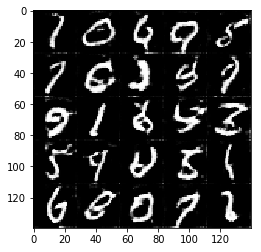

Epoch 2/2... Discriminator Loss: 0.9934... Generator Loss: 0.6966
Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 0.7786
Epoch 2/2... Discriminator Loss: 0.8790... Generator Loss: 0.9214
Epoch 2/2... Discriminator Loss: 0.8955... Generator Loss: 1.1612
Epoch 2/2... Discriminator Loss: 1.0254... Generator Loss: 0.6932


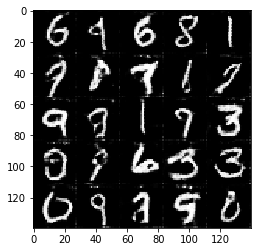

Epoch 2/2... Discriminator Loss: 0.9677... Generator Loss: 1.0014
Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 1.3389
Epoch 2/2... Discriminator Loss: 1.1048... Generator Loss: 0.6080
Epoch 2/2... Discriminator Loss: 0.7881... Generator Loss: 1.0481
Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 0.7580


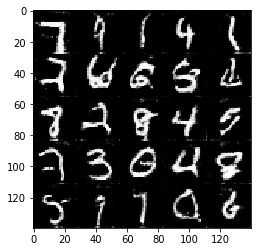

Epoch 2/2... Discriminator Loss: 1.0463... Generator Loss: 0.6798
Epoch 2/2... Discriminator Loss: 0.8852... Generator Loss: 0.9259
Epoch 2/2... Discriminator Loss: 1.4191... Generator Loss: 0.5335
Epoch 2/2... Discriminator Loss: 0.9345... Generator Loss: 0.8588
Epoch 2/2... Discriminator Loss: 0.7329... Generator Loss: 1.2024


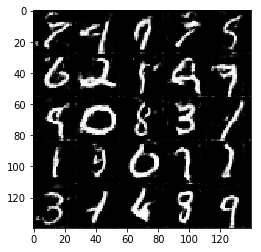

Epoch 2/2... Discriminator Loss: 0.9205... Generator Loss: 1.1050
Epoch 2/2... Discriminator Loss: 1.1091... Generator Loss: 0.7122
Epoch 2/2... Discriminator Loss: 1.2298... Generator Loss: 0.5336
Epoch 2/2... Discriminator Loss: 1.3124... Generator Loss: 0.4324
Epoch 2/2... Discriminator Loss: 0.9704... Generator Loss: 0.7886


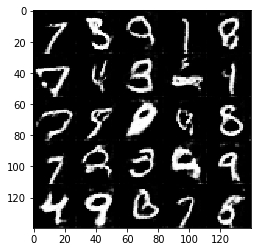

Epoch 2/2... Discriminator Loss: 0.8725... Generator Loss: 1.2970
Epoch 2/2... Discriminator Loss: 1.0522... Generator Loss: 0.9874
Epoch 2/2... Discriminator Loss: 1.3883... Generator Loss: 0.4194
Epoch 2/2... Discriminator Loss: 0.9323... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 0.9602... Generator Loss: 1.8144


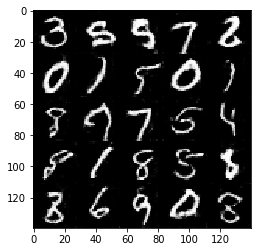

Epoch 2/2... Discriminator Loss: 1.0558... Generator Loss: 0.7331
Epoch 2/2... Discriminator Loss: 0.9081... Generator Loss: 0.8053
Epoch 2/2... Discriminator Loss: 1.0701... Generator Loss: 0.7219


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.00025
beta1 = 0.5
alpha = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.7152... Generator Loss: 0.1154
Epoch 1/1... Discriminator Loss: 1.9648... Generator Loss: 0.3007
Epoch 1/1... Discriminator Loss: 1.5991... Generator Loss: 0.4677
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 1.1293


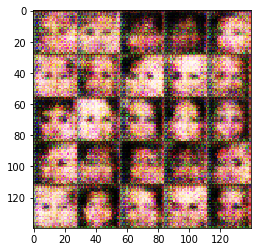

Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 0.6632... Generator Loss: 2.0255
Epoch 1/1... Discriminator Loss: 1.6059... Generator Loss: 0.4679
Epoch 1/1... Discriminator Loss: 1.8173... Generator Loss: 0.3325
Epoch 1/1... Discriminator Loss: 1.8172... Generator Loss: 0.2713


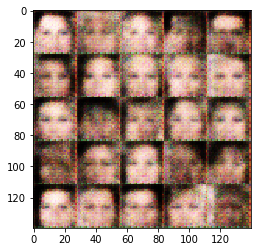

Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 0.3484
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.3578
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 0.7776... Generator Loss: 1.6173
Epoch 1/1... Discriminator Loss: 0.5981... Generator Loss: 1.0771


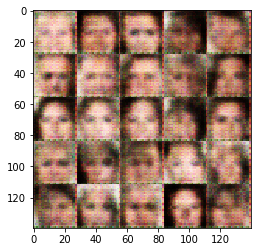

Epoch 1/1... Discriminator Loss: 1.6316... Generator Loss: 0.3538
Epoch 1/1... Discriminator Loss: 1.5952... Generator Loss: 0.4767
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.4859
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 1.1155


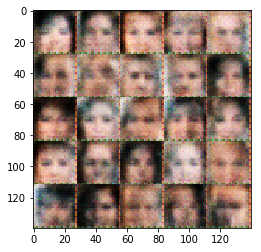

Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 0.6086... Generator Loss: 1.4215
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 0.4414... Generator Loss: 2.2685


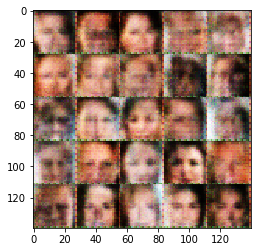

Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.4311
Epoch 1/1... Discriminator Loss: 0.5314... Generator Loss: 1.5533
Epoch 1/1... Discriminator Loss: 2.2452... Generator Loss: 0.1575
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 2.1056
Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 0.9910


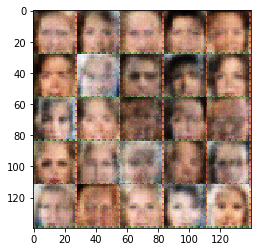

Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 1.3435
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.6027... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.7609


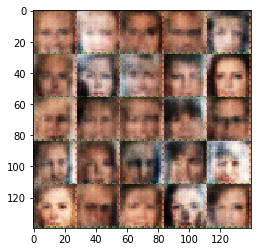

Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.6281


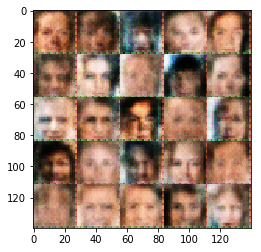

Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.7269


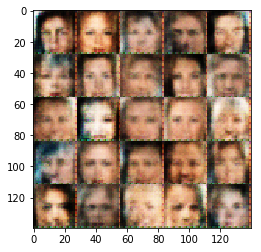

Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.6531


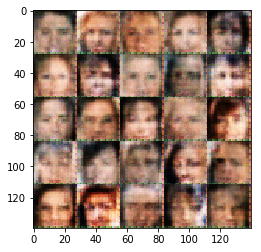

Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6792


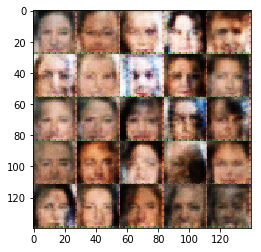

Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.6641


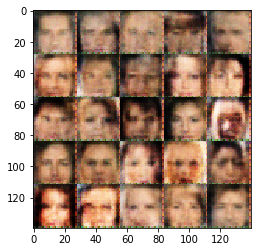

Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.6372


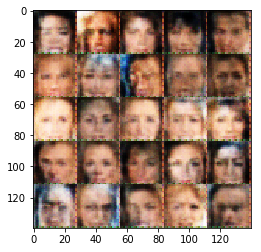

Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6729


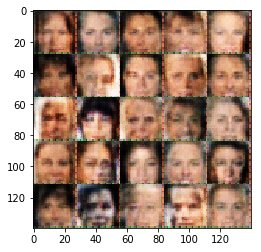

Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.6839


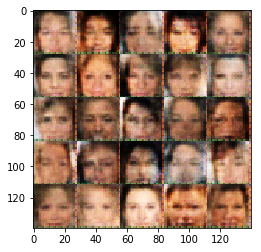

Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.6648


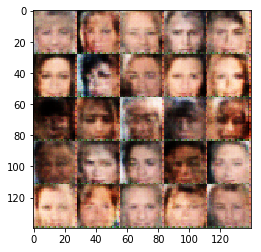

Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.7404


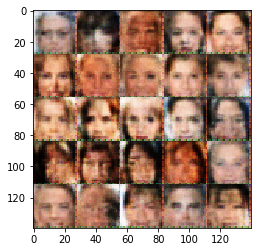

Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.6204


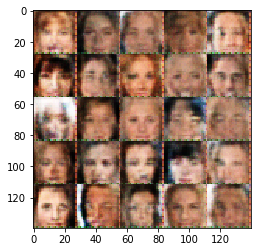

Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.6423


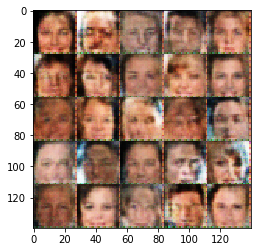

Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.7249


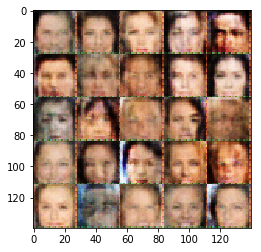

Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.7711


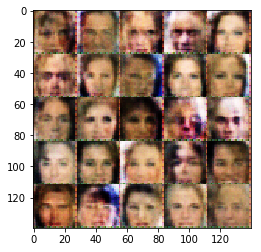

Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 0.3599... Generator Loss: 2.0481
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.5085
Epoch 1/1... Discriminator Loss: 0.6234... Generator Loss: 2.4268
Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 1.0959


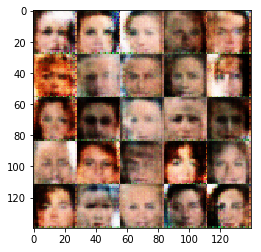

Epoch 1/1... Discriminator Loss: 0.5235... Generator Loss: 2.3024
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 2.7980
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 1.3635
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.5310


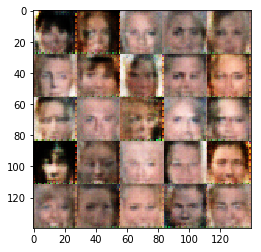

Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.0811
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.5332
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.5491


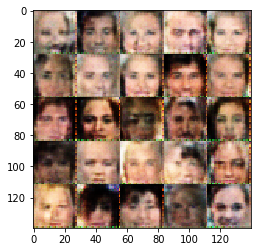

Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.3241
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 1.9905
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 0.8404


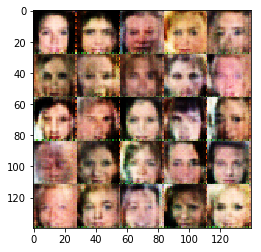

Epoch 1/1... Discriminator Loss: 1.6726... Generator Loss: 0.3000
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 1.1577
Epoch 1/1... Discriminator Loss: 0.6123... Generator Loss: 1.5318
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 0.8474


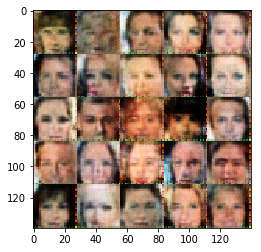

Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.3001


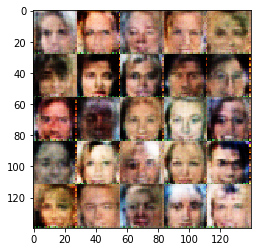

Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.9638
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.3052
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.6387


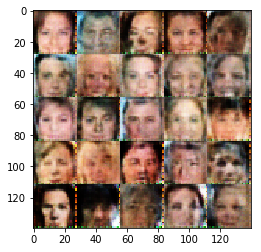

Epoch 1/1... Discriminator Loss: 0.6339... Generator Loss: 1.6756
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.3778
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.5362
Epoch 1/1... Discriminator Loss: 0.5627... Generator Loss: 1.2678
Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 1.4832


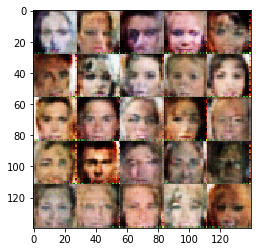

Epoch 1/1... Discriminator Loss: 1.6806... Generator Loss: 0.2967
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 0.4713... Generator Loss: 1.7679
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.5610


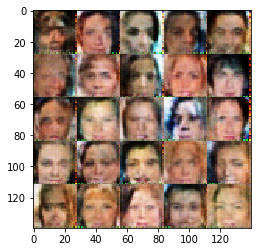

Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 1.1510
Epoch 1/1... Discriminator Loss: 0.2734... Generator Loss: 2.7573
Epoch 1/1... Discriminator Loss: 0.6932... Generator Loss: 2.6830
Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 1.9760


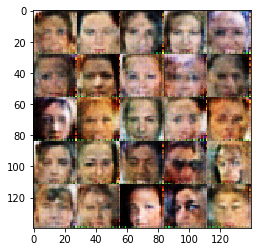

Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 0.5310... Generator Loss: 2.2541
Epoch 1/1... Discriminator Loss: 0.5810... Generator Loss: 1.6057


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.